<div class="alert alert-block alert-success">

# **1.** **Setup**

<div>

In [1]:
from utils import *

In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(221)
random.seed(221)
np.random.seed(221)
tf.random.set_seed(221)

In [3]:
# Load the train/val split data without preprocessing
with open('train_val_split_no_preproc.pkl', 'rb') as f:
    data_no_preproc = pickle.load(f)

# Convert DataFrames to list
train_texts = data_no_preproc['x_train'].tolist()
val_texts = data_no_preproc['x_val'].tolist()

# Convert Series to list
train_labels = data_no_preproc['y_train'].tolist()
val_labels = data_no_preproc['y_val'].tolist()

In [4]:
# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Define embedding model
model = "text-embedding-3-small"

AZURE_OPENAI_ENDPOINT: https://novaimsplayground.openai.azure.com/


<div class="alert alert-block alert-success">

# **2.** **Models**

<div>

## **2.1** CATARINA (Encoder)

## **2.2** CATARINA (Decoder)

## **2.3** Extra

### **2.3.1** RoBERTa (Encoder)

#### **2.3.1.1** Setup

In [17]:
# Prepare Hugging Face Datasets
train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels})
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

In [18]:
# Load RoBERTa tokenizer and model (no sentiment head)
model_checkpoint = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Tokenize the dataset
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding=True, max_length=128)

dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [20]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",                   # Where model checkpoints and logs go
    learning_rate=2e-5,                       # Standard learning rate for fine-tuning
    per_device_train_batch_size=16,           # Small enough for most GPUs
    per_device_eval_batch_size=32,            # Larger eval batch size is okay for speed
    num_train_epochs=5,                       # 4 epochs — sufficient for many transformer tasks
    weight_decay=0.01,                        # Regularization to avoid overfitting
    logging_dir="./logs",                     # Logs directory
    logging_steps=100,                        # Log every 100 steps
    eval_strategy="epoch",                    # Evaluate at the end of every epoch
    save_strategy="no",                    # Save model at the end of every epoch        
    load_best_model_at_end=False,              # Keep best model based on metric
    metric_for_best_model="f1",               # Use F1 to choose the best model
    greater_is_better=True,                   # Because higher F1 is better
    report_to=[]                              # Disable WandB or other loggers
)

In [21]:
# Define metrics
def trainer_compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Data collator for truncation and padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#### **2.3.1.2** Train and Validate

In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=data_collator,
    compute_metrics=trainer_compute_metrics
)

# Train the model
trainer.train()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.039200,0.853240,0.878470,0.884776,0.878470,0.880082
2,0.149900,0.742684,0.875851,0.880145,0.875851,0.876691
3,0.132800,0.643052,0.891566,0.890514,0.891566,0.890723
4,0.033200,0.757844,0.888423,0.889079,0.888423,0.888708
5,0.050100,0.814385,0.884233,0.888757,0.884233,0.885644


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pin

TrainOutput(global_step=2390, training_loss=0.07231285018402163, metrics={'train_runtime': 2121.8095, 'train_samples_per_second': 17.989, 'train_steps_per_second': 1.126, 'total_flos': 2011082741521056.0, 'train_loss': 0.07231285018402163, 'epoch': 5.0})

In [20]:
# Save model and tokenizer
trainer.save_model("roberta-market-sentiment")
tokenizer.save_pretrained("roberta-market-sentiment")

('roberta-market-sentiment/tokenizer_config.json',
 'roberta-market-sentiment/special_tokens_map.json',
 'roberta-market-sentiment/vocab.json',
 'roberta-market-sentiment/merges.txt',
 'roberta-market-sentiment/added_tokens.json',
 'roberta-market-sentiment/tokenizer.json')

In [15]:
# Evaluate on training set
train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
print("\nTraining Set Evaluation Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Evaluate on validation set
val_metrics = trainer.evaluate(eval_dataset=dataset["validation"])
print("\nValidation Set Evaluation Metrics:")
for key, value in val_metrics.items():
    print(f"{key}: {value:.4f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Training Set Evaluation Metrics:
eval_loss: 0.0139
eval_accuracy: 0.9967
eval_precision: 0.9967
eval_recall: 0.9967
eval_f1: 0.9967
eval_runtime: 97.0996
eval_samples_per_second: 78.6200
eval_steps_per_second: 2.4610
epoch: 5.0000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Validation Set Evaluation Metrics:
eval_loss: 0.8144
eval_accuracy: 0.8842
eval_precision: 0.8888
eval_recall: 0.8842
eval_f1: 0.8856
eval_runtime: 21.0067
eval_samples_per_second: 90.8760
eval_steps_per_second: 2.8560
epoch: 5.0000


In [17]:
train_preds = trainer.predict(dataset["train"])
val_preds = trainer.predict(dataset["validation"])

train_pred_roberta = np.argmax(train_preds.predictions, axis=1)
val_pred_roberta = np.argmax(val_preds.predictions, axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [16]:
# Define the title for the metrics and plots
title = "Roberta Market Sentiment"

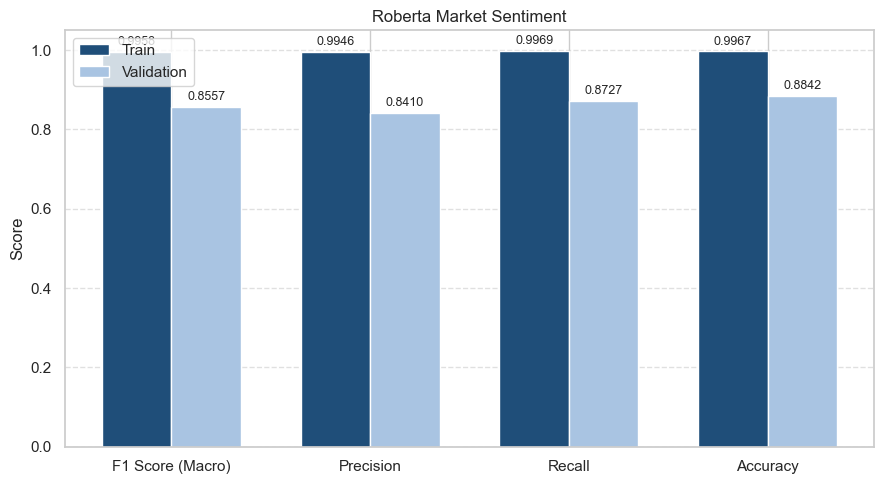

In [18]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels, train_pred_roberta, val_labels, val_pred_roberta)
metrics_df

# Plot metrics
plot_metrics(train_labels, train_pred_roberta, val_labels, val_pred_roberta, title=title)

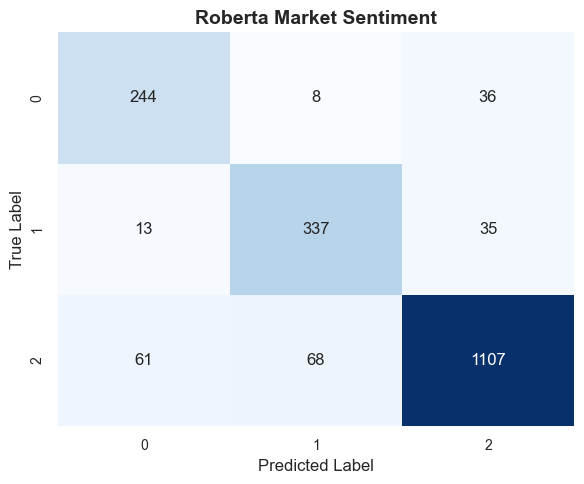

In [19]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

#### **2.3.1.3** Hyperparameter tuning

In [22]:
from optuna import Trial

In [23]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",                   # Where model checkpoints and logs go
    learning_rate=2e-5,                       # Standard learning rate for fine-tuning
    per_device_train_batch_size=16,           # Small enough for most GPUs
    per_device_eval_batch_size=32,            # Larger eval batch size is okay for speed
    num_train_epochs=5,                       # 4 epochs — sufficient for many transformer tasks
    weight_decay=0.01,                        # Regularization to avoid overfitting
    logging_dir="./logs",                     # Logs directory
    logging_steps=100,                        # Log every 100 steps
    eval_strategy="epoch",                    # Evaluate at the end of every epoch
    save_strategy="epoch",                    # Save model at the end of every epoch  
    save_total_limit=1,      
    load_best_model_at_end=True,              # Keep best model based on metric
    metric_for_best_model="f1",               # Use F1 to choose the best model
    greater_is_better=True,                   # Because higher F1 is better
    report_to=[]                              # Disable WandB or other loggers
)

In [24]:
# hyperparameter space
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        "cardiffnlp/twitter-roberta-base", 
        num_labels=3
    )


def hp_space_random(trial: Trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 6),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3)
    }

In [25]:
trainer = Trainer(
    model_init=model_init,  # reinitialize the model
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=data_collator,
    compute_metrics=trainer_compute_metrics
)

# random search
best_trial = trainer.hyperparameter_search(
    direction="maximize", 
    n_trials=15,           
    hp_space=hp_space_random,
    backend="optuna",         
)

print(best_trial)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-14 12:50:01,380] A new study created in memory with name: no-name-94ed575d-4db9-48e9-a896-3b113e1b975a
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


[W 2025-06-14 13:00:06,121] Trial 0 failed with parameters: {'learning_rate': 3.5965177993150904e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.17619264877380833, 'warmup_ratio': 0.2192867035242916} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/integrations/integration_utils.py", line 255, in _objective
    trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/trainer.py", line 2240, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/V

KeyboardInterrupt: 

In [ ]:
print("Best hyperparameters:", best_trial.hyperparameters)

# train a new model with these best params
best_args = training_args.clone()
for k, v in best_trial.hyperparameters.items():
    setattr(best_args, k, v)

best_model = model_init()
best_trainer = Trainer(
    args=best_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=trainer_compute_metrics,
    data_collator=data_collator,
)
best_trainer.train()

In [ ]:
# Get predictions for train and val sets
train_preds = best_trainer.predict(dataset["train"])
val_preds = best_trainer.predict(dataset["validation"])

train_labels = train_preds.label_ids
train_pred_labels = np.argmax(train_preds.predictions, axis=1)

val_labels = val_preds.label_ids
val_pred_labels = np.argmax(val_preds.predictions, axis=1)

In [ ]:
title = "Best RoBERTa Model Performance (Optuna)"

In [ ]:
metrics_df = get_metrics_df(title, train_labels, train_pred_labels, val_labels, val_pred_labels)
display(metrics_df)

plot_metrics(train_labels, train_pred_labels, val_labels, val_pred_labels, title=title)

In [ ]:
output_path = "./best_roberta_model"
best_model.save_pretrained(output_path)
tokenizer.save_pretrained(output_path)

### **2.3.2** GPT-4o (Decoder)

In [6]:
# Convert Series to list and ensure labels are strings
train_labels = [str(label) for label in data_no_preproc['y_train'].tolist()]
val_labels = [str(label) for label in data_no_preproc['y_val'].tolist()]

In [7]:
# For reproducibility
random.seed(42)

# Label options
label_options = sorted(list(set(train_labels)))

# Generate few-shot examples
few_shot_examples = []
for label in label_options:
    examples = [(t, l) for t, l in zip(train_texts, train_labels) if l == label]
    sample = random.choice(examples)
    few_shot_examples.append({'text': sample[0], 'label': sample[1]})

# Print few-shot examples
print("Few-shot examples:")
for example in few_shot_examples:
    print(f"Text: {example['text']}, Label: {example['label']}")

Few-shot examples:
Text: Employee furloughs in the retail industry are now well over 1 million after one of America's biggest clothing store… https://t.co/eFPius4T5H, Label: 0
Text: Coca-Cola Breaks Down a Record Quarter, Label: 1
Text: Celebrity lawyer Michael Avenatti says evidence of his spending, as well of a $5 million debt, is irrelevant to the… https://t.co/9f5go0fwTx, Label: 2


In [8]:
# Run (or load cached) classification
train_pred_gpt4o = cached_classification_run("gpt4o_train_preds.pkl", train_texts, label_options, few_shot_examples, client=client, force_reload=False, batch_size=16)
val_pred_gpt4o = cached_classification_run("gpt4o_val_preds.pkl", val_texts, label_options, few_shot_examples, client=client, force_reload=False, batch_size=16)

No cache found. Running classification and saving to gpt4o_train_preds.pkl


Classifying with GPT-4o:   0%|          | 0/478 [00:00<?, ?it/s]

Classifying with GPT-4o:   0%|          | 2/478 [01:11<4:43:44, 35.76s/it]


KeyboardInterrupt: 

In [ ]:
# # Filter out unkown labels from both predictions and labels before computing metrics
# clean_preds = []
# clean_labels = []

# for pred, label in zip(train_pred_gpt4o, train_labels):
#     if pred != "unknown":
#         clean_preds.append(pred)
#         clean_labels.append(label)

In [ ]:
# Convert to np.array
X_train_gpt40 = np.array(train_pred_gpt4o)
X_val_gpt40 = np.array(val_pred_gpt4o)

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [ ]:
# Define the title for the metrics and plots
title = "GPT-4o with Few-shot Examples"

,Model,Train F1 (Macro),Val F1 (Macro),Train Precision,Val Precision,Train Recall,Val Recall,Train Accuracy,Val Accuracy
0,GPT-4o with with few-shot examples,0.3926,0.3056,0.5111,0.2222,0.5952,0.5,0.4,0.3


In [ ]:
# Get metrics DataFrame
metrics_df = get_metrics_df(title, train_labels, train_pred_gpt4o, val_labels, val_pred_gpt4o)
metrics_df

# Plot metrics
plot_metrics(train_labels, train_pred_gpt4o, val_labels, val_pred_gpt4o, title=title)

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, val_pred_gpt4o, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.3.3** BERT

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = "siebert/sentiment-roberta-large-english"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    ignore_mismatched_sizes=True 
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:799: UserWarning: Not enough free disk space to download the file. The expected file size is: 1421.50 MB. The target location /Users/brunasimoes/.cache/huggingface/hub/models--siebert--sentiment-roberta-large-english/blobs only has 491.42 MB free disk space.
  warnings.warn(


model.safetensors:  27%|##6       | 514M/1.94G [00:00<?, ?B/s]

In [10]:
# Tokenize the dataset
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding=True, max_length=128)

dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [6]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_siebert",
    num_train_epochs=4,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1, 
    logging_dir="./logs_siebert",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[]  # disable WandB
)

In [14]:
from transformers import Trainer, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/var/folders/vr/c8clls693rl3z4mp61z036p80000gn/T/ipykernel_9892/2027591878.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Predict on train and validation sets
train_preds = trainer.predict(dataset["train"])
val_preds = trainer.predict(dataset["validation"])

# Extract labels and predicted classes
train_labels = train_preds.label_ids
train_pred_labels = np.argmax(train_preds.predictions, axis=1)

val_labels = val_preds.label_ids
val_pred_labels = np.argmax(val_preds.predictions, axis=1)

In [ ]:
title = "SieBERT (RoBERTa-Large) Performance"

# Assuming you have this function already:
metrics_df = get_metrics_df(title, train_labels, train_pred_labels, val_labels, val_pred_labels)
display(metrics_df)

# Plot using your function
plot_metrics(train_labels, train_pred_labels, val_labels, val_pred_labels, title=title)
